In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


# Data Preprocessing

In [2]:
# Set the random seed
random_seed = 135791113

def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    X_train = x_train.astype('float32')
    X_test = x_test.astype('float32')
    return X_train, y_train, X_test, y_test

def labelencoding(y_train, y_val, y_test, nb_classes):
    Y_val = to_categorical(y_val, num_classes = nb_classes)
    Y_test = to_categorical(y_test, num_classes = nb_classes)
    Y_train = to_categorical(y_train.reshape(-1, 1), num_classes = nb_classes)
    return Y_train, Y_val, Y_test

def split_dataset(X_train, Y_train):

    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)
    
    return X_train, X_val, Y_train, Y_val

In [3]:
CLASSES = 10
X_train, Y_train, X_test, Y_test = load_data()
#X_train, X_val, Y_train, Y_val = split_dataset(X_train, Y_train)
#Y_train, Y_val, Y_test = labelencoding(Y_train, Y_val, Y_test, CLASSES)

## Normalization

In [4]:
#X_train = X_train / 255.

#X_val = X_val / 255.

X_test = X_test / 255.

# Model: VGG-like convnet

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense_1"))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', name="dense_2"))

## Model compilation

In [6]:
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

## Load Weights

In [7]:
weights_path = "weights/cifar10/weights.18-0.74.hdf5"
model.load_weights(weights_path)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

## Drop the clasification layer

In [9]:
model = Model(inputs=model.input, outputs=model.get_layer('dense_1').output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
__________

# Predict

In [10]:
feats = model.predict(X_test)
print(feats.shape)
Y_test = Y_test.reshape(1,-1)[0]

(10000, 256)


## PCA: Dimensionality reduction

In [11]:
pca = PCA(n_components=3)
feats = pca.fit_transform(feats)
print("Feature shape: {}".format(feats.shape))

Feature shape: (10000, 3)


In [12]:
nb_examples = 10
f = []
l = []
for cat in range(10):
    idx = np.where(Y_test==cat)[0][:nb_examples]
    for ii in range(nb_examples):
        l.append(cat)
        f.append(feats[idx][ii])
f = np.array(f)
l = np.array(l)

## 3D Plot

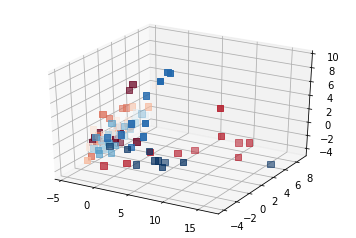

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(f[:,0], f[:,1], f[:,2], marker="s", c=l, s=40, cmap="RdBu")
plt.show()